In [1]:
import numpy as np
import sys
import os.path
import glob
from matplotlib import pyplot as plt
import mplhep as hep 
plt.style.use(hep.style.CMS) # CMS plot style
from src.loca import *
t0=timer()

# Search Inputs

In [54]:
lhco_file='data/MU_1500_delphes_events.lhco'
process='p p --> τ+ τ-'
search_description='''Recast of ATLAS search arXiv:2002.12223: 
'SEARCH FOR HEAVY HIGGS BOSONS DECAYING INTO TWO TAU LEPTONS WITH
THE ATLAS DETECTOR USING pp COLLISIONS AT SQRT(S)=13 TEV'
Phys. Rev. Lett. 125 (2020) 051801'''
Luminosity=139.0 # fb^-1
rel_s_err=0.2

# Cuts

In [55]:
#...Pre-cuts:

basic_cuts = {                    
        'e'     : [15.0 , 1e+10 ,  2.47],   #[pt_min, pt_max, abs(eta_max)] 
        'mu'    : [7.0  , 1e+10 ,  2.5],
        'tau'   : [65.0 , 1e+10 ,  2.5],
        'jet'   : [20.0 , 1e+10 ,  2.5],
        'bjet'  : [20.0 , 1e+10 ,  2.5],
        'met'   : [0.0  , 1e+10 ,  1e+10],
        'photon': [0.0  , 1e+10 ,  1e+10] 
         }

#...Signal region defintion:

Category_τhad_τhad = category(
        'nleps = 0',
        'ntaus >= 2',
        'pt(τ1)>130',
        'OS ττ',
        '|dphi|>2.7',
        'b-veto category',
        'b-tag category' )

#...Observable:

MTtot=spectrum(name='MTtot_τhad')


# Event selection

In [56]:
# ============================================================================
# start search:

lhco=open_lhco(file=lhco_file, cuts=basic_cuts, lhco_header=True)
xsec=lhco.parameters['xsec']

with lhco as events:   
    for N, event in events:
        
#.......tau_had tau_had category:
        Category_τhad_τhad.start_cutflow(name='τhad')
    
        if event.nleps==0:
            Category_τhad_τhad.apply_cut('nleps = 0')
            
            if event.ntaus>=2:
                Category_τhad_τhad.apply_cut('ntaus >= 2')
                
                τ1=event.tau_leading
                τ2=event.tau_subleading
                
                if τ1.pt>130.0:
                    Category_τhad_τhad.apply_cut('pt(τ1)>130')
                    
                    if τ1.charge==-τ2.charge: 
                        Category_τhad_τhad.apply_cut('OS ττ')
                        
                        if abs(τ1.dphi(τ2))>2.7:
                            Category_τhad_τhad.apply_cut('|dphi|>2.7')
                            
                            if event.nbjets==0:
                                Category_τhad_τhad.apply_cut('b-veto category')
                                MTtot.extract_spectrum( τ1.MTtot(τ2,event.met) )
                            else:
                                Category_τhad_τhad.apply_cut('b-tag category')

print('xsec={}'.format(xsec))

xsec=0.85839


# Hep data

In [57]:
import yaml

with open("data/HEPData-ins1782650-v4-Table_3.yml", 'r') as stream:
    hepdata=yaml.safe_load(stream)
    
bins=[hepdata['independent_variables'][0]['values'][0]['low']]+[b['high'] for b in hepdata['independent_variables'][0]['values']]
nobs=[int(vals['value']) for vals in hepdata['dependent_variables'][0]['values']]
backgr=[vals['value'] for vals in hepdata['dependent_variables'][1]['values']]
b_err=[]
for vals in hepdata['dependent_variables'][1]['values']:
    errors2=np.sum([(float(err['symerror'].split('%')[0])*vals['value']/100)**2 for err in vals['errors']])
    b_err.append(round(np.sqrt(errors2),2))

# Results



----- Results ----
process: p p --> τ+ τ-
description: Recast of ATLAS search arXiv:2002.12223: 
'SEARCH FOR HEAVY HIGGS BOSONS DECAYING INTO TWO TAU LEPTONS WITH
THE ATLAS DETECTOR USING pp COLLISIONS AT SQRT(S)=13 TEV'
Phys. Rev. Lett. 125 (2020) 051801
-----

category: τhad
num events = 100000
cutflow:
- nleps = 0 : 99925 (0.99925)
-- ntaus >= 2 : 27970 (0.2797)
--- pt(τ1)>130 : 22374 (0.22374)
---- OS ττ : 22109 (0.22109)
----- |dphi|>2.7 : 19496 (0.19496)
------ b-veto category : 14242 (0.14242)
------- b-tag category : 5254 (0.05254)




'FiraMath-Ultra.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


effs=[2e-05, 0.00214, 0.01571, 0.01842, 0.01715, 0.0142, 0.01196, 0.01837, 0.01292, 0.0094, 0.00608, 0.00432, 0.00439, 0.00473]
done! time: time: 42.40783218431667 min


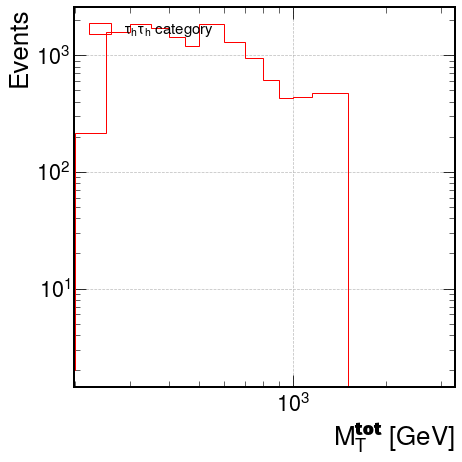

In [58]:
#=========
# Outputs:

search_results(Category_τhad_τhad).print(process=process, description=search_description, save_file=True)
raw_signal=list(MTtot.bin_data(bins=bins,overflow=False))  

#======
# Plot:

fig = plt.figure(figsize=(7,7))
MTtot.plot(fig=fig, bins=bins, xlabel=r'$M_T^{\mathrm{tot}}$ [GeV]', loglog=True, density=False, label=r'$\tau_h\tau_h$ category', color='red')
plt.savefig('MTtot_spectra.pdf')
print('effs={}'.format([round(s/N,6) for s in raw_signal]))
#====
# end

print('done! time: {}'.format(elapsed_time(t0)))



# Statistical Analysis

In [59]:
# import yaml


with open("data/HEPData-ins1782650-v4-Table_3.yml", 'r') as stream:
    hepdata=yaml.safe_load(stream)
    
bins=[hepdata['independent_variables'][0]['values'][0]['low']]+[b['high'] for b in hepdata['independent_variables'][0]['values']]
nobs=[int(vals['value']) for vals in hepdata['dependent_variables'][0]['values']]
backgr=[vals['value'] for vals in hepdata['dependent_variables'][1]['values']]
b_err=[]
for vals in hepdata['dependent_variables'][1]['values']:
    errors2=np.sum([(float(err['symerror'].split('%')[0])*vals['value']/100)**2 for err in vals['errors']])
    b_err.append(round(np.sqrt(errors2),2))

    
BR=1.-0.17    
signal=[round(BR*BR*xsec*s*Luminosity/N,3) for s in raw_signal]
s_err=[s*rel_s_err for s in signal] # 20% unc in signal

print('nobs={}'.format(nobs))
print('signal={}'.format(signal))
print('backgr={}'.format(backgr)) 
print('b_err={}'.format(b_err)) 
print('s_err={}'.format(s_err)) 



nobs=[1167, 1568, 1409, 1455, 1292, 650, 377, 288, 92, 57, 27, 14, 11, 13]
signal=[0.002, 0.176, 1.291, 1.514, 1.41, 1.167, 0.983, 1.51, 1.062, 0.773, 0.5, 0.355, 0.361, 0.389]
backgr=[1125.2, 1498.3, 1434.54, 1495.3, 1276.9, 656.11, 353.42, 327.85, 123.3, 61.49, 33.42, 17.43, 11.97, 10.65]
b_err=[23.5, 34.03, 41.02, 65.7, 86.67, 56.71, 34.59, 35.38, 15.62, 7.91, 4.38, 2.47, 1.93, 2.1]
s_err=[0.0004, 0.0352, 0.2582, 0.3028, 0.282, 0.23340000000000002, 0.1966, 0.30200000000000005, 0.21240000000000003, 0.15460000000000002, 0.1, 0.071, 0.0722, 0.07780000000000001]


In [ ]:
alpha=0.05  # C.L.
mu_min,mu_max,dmu= 1, 20, 20 
calctype='asymptotics'    
ntoys=None
#===================================================================


model_json = my_json_model(nobs,signal,backgr,s_err,b_err)
ws = pyhf.Workspace(model_json)
model = ws.model()
data = ws.data(model)

hypo_tests=[]
mu_tests=np.linspace(mu_min, mu_max, dmu)
for mu in mu_tests:
    try:
        CLs = pyhf.infer.hypotest(
                        mu,
                        data,
                        model,
                        calctype=calctype,
                        ntoys=ntoys,
                        qtilde=True,
                        return_expected_set=True
                        )
    except AssertionError:
        continue
    hypo_tests.append(CLs)
    
results = invert_interval(mu_tests, hypo_tests)
print('-----------------------------------------------')
print('Observed Limit on μ: {}'.format(results['obs']))
print('-----------------------------------------------')
for i, n_sigma in enumerate(np.arange(-2,3)):
    print('Expected Limit{} on μ: {}'.format('' if n_sigma==0 else '({} σ)'.format(n_sigma),results['exp'][i]))

    
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(7, 5)
ax1.set_title(u"Hypothesis Tests")
ax1.set_ylabel(r"$CL_s$")
ax1.set_xlabel(r"$\mu$ (signal modifier)")
pyhf.contrib.viz.brazil.plot_results(ax1, [mu for mu in mu_tests], hypo_tests);
plt.xlim([mu_min,mu_max])
plt.tight_layout()
plt.savefig('./CLs_plot.pdf')
print('-----------------------------------------------')
print('gU < {} at 95% CL'.format(round(results['obs']**0.25,3)))
print('-----------------------------------------------')


In [52]:
results['obs']**0.25


1.1431779776179212

# Limits for gU [only LH couplings]

from bb --> tau+ tau-

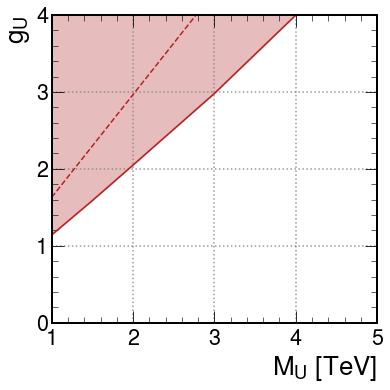

In [53]:


gU=[1.14318,1.5894,2.0504,2.5156,2.9807,3.998226]
MU=[1.000,1.500,2.000,2.500,3.000,4.000]

plt.style.use([hep.style.CMS, hep.style.firamath])

fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
#ax.scatter(x=MU, y=gU, label="XSX")
plt.plot([1.000,2.775],[1.63,4.0], color='firebrick', ls='--')
plt.plot(MU, gU, color='firebrick')
ax.fill_between(MU, gU, 4, color='firebrick',alpha=0.3)
plt.xlim([1.000,5.000])
plt.ylim([0,4])
ax.set_ylabel(u"$g_U$")
ax.set_xlabel(u"$M_U$ [TeV]")
plt.tight_layout()
plt.grid(True, color='gray', ls=':', lw=1.5)
plt.show()

In [34]:
[mu**0.25 for mu in results['obs']]

TypeError: 'numpy.float64' object is not iterable